In [53]:
pip install catboost


In [54]:
!pip install folium

In [55]:
!pip install plotly


In this section, I imported essential Python libraries for data analysis, visualization, and machine learning.

- **pandas** and **numpy**: For data manipulation.
- **matplotlib** and **seaborn**: For data visualization.
- **scikit-learn** models and tools: For building classification models.
- **catboost**, **lightGBM**, and **imbalanced-learn (SMOTE)**: For boosting and handling imbalanced data.
- I also disabled warnings to keep the notebook clean and readable.

This setup helps me provide a comprehensive base for performing advanced EDA, preprocessing, and model development.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.mstats import winsorize

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Model Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import pickle

# Model Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import pickle

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To conduct a geographically diverse and insightful analysis of air quality, I selected five representative monitoring sites across different regions of Beijing. These stations were chosen to cover a range of environmental and socio-economic conditions, which helps in understanding how pollution levels vary across urban, rural, and industrial landscapes.

- **Aotizhongxin (Industrial)**: This site is located near Beijing’s Olympic Sports Center, a zone that also includes dense traffic and industrial activity. Including this station provides insights into pollution in high-activity urban-industrial zones.

- **Dongsi (Urban)**: Located in the city center, Dongsi is a densely populated urban area with heavy traffic. It helps to analyze typical urban pollution levels where population exposure is highest.

- **Changping (Suburban)**: Positioned at the edge of urban expansion, Changping is undergoing rapid residential and commercial development. It offers a middle ground between urban and rural, useful for detecting early signs of pollution creep from the city.

- **Huairou (Rural)**: This site is in a mountainous area with low human activity and fewer pollution sources. It serves as a baseline for comparing air quality in less polluted, greener regions.

- **Shunyi (Semi-Rural / Airport Zone)**: Shunyi is located near Beijing Capital Airport and is less densely populated, yet influenced by aircraft emissions and suburban transport. It provides a unique perspective on non-industrial, transport-related pollution in outer zones.

This carefully chosen mix allows for comparisons between different types of areas and supports meaningful geographical disadvantage analysis, a key aim of this project.


In [58]:
# Load your selected CSVs
df_aoti = pd.read_csv('/content/drive/MyDrive/Assignment/PRSA_Data_Aotizhongxin_20130301-20170228.csv')
df_changping = pd.read_csv('/content/drive/MyDrive/Assignment/PRSA_Data_Changping_20130301-20170228.csv')
df_dongsi = pd.read_csv('/content/drive/MyDrive/Assignment/PRSA_Data_Dongsi_20130301-20170228.csv')
df_huairou = pd.read_csv('/content/drive/MyDrive/Assignment/PRSA_Data_Huairou_20130301-20170228.csv')  # rural
df_shunyi = pd.read_csv('/content/drive/MyDrive/Assignment/PRSA_Data_Shunyi_20130301-20170228.csv')    # semi-rural

In [59]:
# Add station name
df_aoti['station'] = 'Aotizhongxin'
df_changping['station'] = 'Changping'
df_dongsi['station'] = 'Dongsi'
df_huairou['station'] = 'Huairou'
df_shunyi['station'] = 'Shunyi'

In [60]:
coords = {
    'Aotizhongxin': [39.982, 116.397],
    'Dongsi': [39.929, 116.417],
    'Changping': [40.218, 116.231],
    'Huairou': [40.317, 116.637],
    'Shunyi': [40.125, 116.655],
}

# Add lat/lon to the DataFrame
df['lat'] = df['station'].map(lambda x: coords[x][0])
df['lon'] = df['station'].map(lambda x: coords[x][1])



To perform meaningful geographical analysis, I added a new column called `area_type` to each station's dataset.

This column labels each station according to its location type:
- Urban
- Rural
- Suburban
- Industrial
- Semi-Rural

This will allow me to group and compare pollution levels and weather patterns based on location type, making the analysis more insightful and structured. It also prepares the data for grouped visualizations and modeling later on.


In [61]:
# Add area type (geographic context)
df_aoti['area_type'] = 'Industrial'
df_changping['area_type'] = 'Suburban'
df_dongsi['area_type'] = 'Urban'
df_huairou['area_type'] = 'Rural'
df_shunyi['area_type'] = 'Semi-Rural'

After loading the five selected air quality datasets, I added two new columns to each of them:

1. `station` – to identify which monitoring site the data is from.
2. `area_type` – to categorize each station based on its location (e.g., Urban, Rural, Industrial, etc.).

Once the columns were added, I merged all the individual datasets into one using `pd.concat()`. This allowed me to work with one big DataFrame instead of multiple files. I also dropped the `No` column since it was just an index and didn’t add any value to the analysis.

By combining everything into a single DataFrame called `df_all`, I now have a clean, organized dataset that covers a variety of regions in Beijing. This makes it easier to compare how air pollution and weather conditions change based on where the station is located. It also sets things up nicely for grouped analysis and modeling later on.



In [62]:
# Combine all into one DataFrame
df = pd.concat([df_aoti, df_changping, df_dongsi, df_huairou, df_shunyi], ignore_index=True)


In [63]:
# Drop the 'No' column if it exists
df.drop(['No'],axis=1,inplace=True, errors='ignore')


In [64]:
# View sample rows
df[['station', 'area_type']].drop_duplicates()

,station,area_type
0,Aotizhongxin,Industrial
35064,Changping,Suburban
70128,Dongsi,Urban
105192,Huairou,Rural
140256,Shunyi,Semi-Rural


In [65]:
df.head(10)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,area_type
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,Industrial
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,Industrial
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,Industrial
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,Industrial
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,Industrial
5,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,-2.2,1025.6,-19.6,0.0,N,3.7,Aotizhongxin,Industrial
6,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,-2.6,1026.5,-19.1,0.0,NNE,2.5,Aotizhongxin,Industrial
7,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,-1.6,1027.4,-19.1,0.0,NNW,3.8,Aotizhongxin,Industrial
8,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,0.1,1028.3,-19.2,0.0,NNW,4.1,Aotizhongxin,Industrial
9,2013,3,1,9,3.0,8.0,12.0,28.0,400.0,59.0,1.2,1028.5,-19.3,0.0,N,2.6,Aotizhongxin,Industrial


**EDA**

In [66]:
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (175320, 18)

Data Types:
 year           int64
month          int64
day            int64
hour           int64
PM2.5        float64
PM10         float64
SO2          float64
NO2          float64
CO           float64
O3           float64
TEMP         float64
PRES         float64
DEWP         float64
RAIN         float64
wd            object
WSPM         float64
station       object
area_type     object
dtype: object

Missing Values:
 year             0
month            0
day              0
hour             0
PM2.5         4315
PM10          3178
SO2           4502
NO2           6295
CO           10094
O3            5627
TEMP           195
PRES           194
DEWP           200
RAIN           197
wd            1084
WSPM           164
station          0
area_type        0
dtype: int64


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175320 entries, 0 to 175319
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       175320 non-null  int64  
 1   month      175320 non-null  int64  
 2   day        175320 non-null  int64  
 3   hour       175320 non-null  int64  
 4   PM2.5      171005 non-null  float64
 5   PM10       172142 non-null  float64
 6   SO2        170818 non-null  float64
 7   NO2        169025 non-null  float64
 8   CO         165226 non-null  float64
 9   O3         169693 non-null  float64
 10  TEMP       175125 non-null  float64
 11  PRES       175126 non-null  float64
 12  DEWP       175120 non-null  float64
 13  RAIN       175123 non-null  float64
 14  wd         174236 non-null  object 
 15  WSPM       175156 non-null  float64
 16  station    175320 non-null  object 
 17  area_type  175320 non-null  object 
dtypes: float64(11), int64(4), object(3)
memory usage: 24.1+ MB


In [68]:
df['wd'].unique()

array(['NNW', 'N', 'NW', 'NNE', 'ENE', 'E', 'NE', 'W', 'SSW', 'WSW', 'SE',
       'WNW', 'SSE', 'ESE', 'S', 'SW', nan], dtype=object)

In [69]:
df['wd'].value_counts()

,count
wd,
NE,16004
NW,15553
N,12952
ENE,12558
NNE,12519
WNW,12252
E,11911
NNW,11377
ESE,10608


In [70]:
df['station'].unique()

array(['Aotizhongxin', 'Changping', 'Dongsi', 'Huairou', 'Shunyi'],
      dtype=object)

In [71]:
df['station'].value_counts()

,count
station,
Aotizhongxin,35064
Changping,35064
Dongsi,35064
Huairou,35064
Shunyi,35064


In [72]:
df['PM2.5'] = df.groupby('area_type')['PM2.5'].transform(lambda x: x.fillna(x.median()))

To provide a visual understanding of how air pollution varies by geography, I used `Folium` to create an interactive map of the five selected air-quality stations in Beijing.

Each station is shown as a circle marker:
- **Green**: Low pollution (PM2.5 ≤ 75)
- **Orange**: Medium (75 < PM2.5 ≤ 100)
- **Red**: High pollution (PM2.5 > 100)

This map gives an intuitive overview of the air quality disparity across urban, suburban, rural, and industrial areas. It enhances the analysis by making the spatial aspect of pollution easy to interpret.


In [73]:
def pm25_level(val):
    if val <= 35:
        return 'Good'
    elif val <= 75:
        return 'Moderate'
    elif val <= 115:
        return 'Unhealthy for Sensitive'
    elif val <= 150:
        return 'Unhealthy'
    else:
        return 'Very Unhealthy'

df['PM2.5_category'] = df['PM2.5'].apply(pm25_level)



To make the dataset richer and more suitable for analysis, I engineered new features:

- **PM2.5_severity**: A numerical representation of pollution category, useful for visualizations and correlations.
- **Wind risk**: A custom feature that highlights when calm winds might trap pollution in an area.
- **PM25_to_wind ratio**: Shows how effectively wind disperses pollutants in each area.

These features make the dataset more insightful and are expected to improve the performance of any models trained on this data.


In [74]:
severity_map = {'Good': 1, 'Moderate': 2, 'Unhealthy for Sensitive': 3, 'Unhealthy': 4, 'Very Unhealthy': 5}
df['PM2.5_severity'] = df['PM2.5_category'].map(severity_map)


In [75]:
# If wind is calm and pollution is high, mark it
df['wind_risk'] = df.apply(lambda x: 'Trapped' if x['wd'] == 'calm' and x['PM2.5'] > 100 else 'Normal', axis=1)


In [82]:
df['PM25_to_wind'] = df['PM2.5'] / (df['WSPM'] + 1)


To improve performance and clarity, I used animated air quality map with daily averages. To make the animation run more smoothly I ommited the hourly averages and took daily.

Each bubble represents a station, and its color and size reflect the average PM2.5 level for that day. This visualization clearly shows pollution trends across different locations over time.


In [78]:
df_map = df[df['year'] == 2016].copy()


In [80]:
import plotly.express as px

fig = px.scatter_mapbox(
    df_daily,
    lat="lat",
    lon="lon",
    color="PM2.5",
    size="PM2.5",
    size_max=30,
    animation_frame=df_daily["date"].dt.strftime('%Y-%m-%d'),
    animation_group="station",
    hover_name="station",
    color_continuous_scale="Turbo",
    mapbox_style="carto-positron",
    zoom=8,
    center={"lat": 39.9, "lon": 116.4},
    title="Daily PM2.5 Levels Across Beijing Monitoring Stations"
)

fig.show()


To further explore the trend of air pollution over time, I created a line plot showing daily average PM2.5 levels for each monitoring station.

This plot helps identify:
- Which areas consistently experience higher pollution
- Seasonal trends (e.g., winter spikes)
- How pollution changes together or differently across regions

Combined with the animated map, this line chart provides both spatial and temporal perspectives of air quality in Beijing.


In [84]:
import plotly.express as px

fig = px.line(
    df_daily,
    x="date",
    y="PM2.5",
    color="station",
    title="Daily Average PM2.5 Levels by Station",
    labels={"PM2.5": "PM2.5 Concentration", "date": "Date"},
    line_shape="spline"
)

fig.show()


In [85]:
df.head()


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,RAIN,wd,WSPM,station,area_type,PM2.5_category,PM2.5_severity,wind_risk,date,PM25_to_wind
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,0.0,NNW,4.4,Aotizhongxin,Industrial,Good,1,Normal,2013-03-01,0.740741
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,0.0,N,4.7,Aotizhongxin,Industrial,Good,1,Normal,2013-03-01,1.403509
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,0.0,NNW,5.6,Aotizhongxin,Industrial,Good,1,Normal,2013-03-01,1.060606
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,0.0,NW,3.1,Aotizhongxin,Industrial,Good,1,Normal,2013-03-01,1.463415
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,0.0,N,2.0,Aotizhongxin,Industrial,Good,1,Normal,2013-03-01,1.000000


To understand how often different pollution levels occur in the dataset, I used `value_counts()` on the `PM2.5_category` column. This tells me how many observations fall into each pollution category (e.g., Low, Medium, High).

This step gives an initial overview of air quality severity distribution across the dataset and sets the stage for further visualization.


In [87]:
df['PM2.5_category'].value_counts()

,count
PM2.5_category,
Good,66020
Moderate,44142
Unhealthy for Sensitive,25868
Very Unhealthy,25157
Unhealthy,14133


I checked for missing values across all columns using `isnull().sum()`. This is a basic but crucial step in data cleaning, as missing values can affect model performance and analysis.

Based on the result, I decided which columns needed to be imputed or ignored for analysis.


In [89]:
df.isnull().sum()


,0
year,0
month,0
day,0
hour,0
PM2.5,0
PM10,3178
SO2,4502
NO2,6295
CO,10094
O3,5627


I created histograms with KDE (kernel density estimate) plots for all numerical features. This helps visualize the distribution of each variable and identify any skewness, outliers, or abnormal patterns.

This step also gives a better understanding of pollutant levels and meteorological factors like temperature, pressure, and wind speed across the dataset.


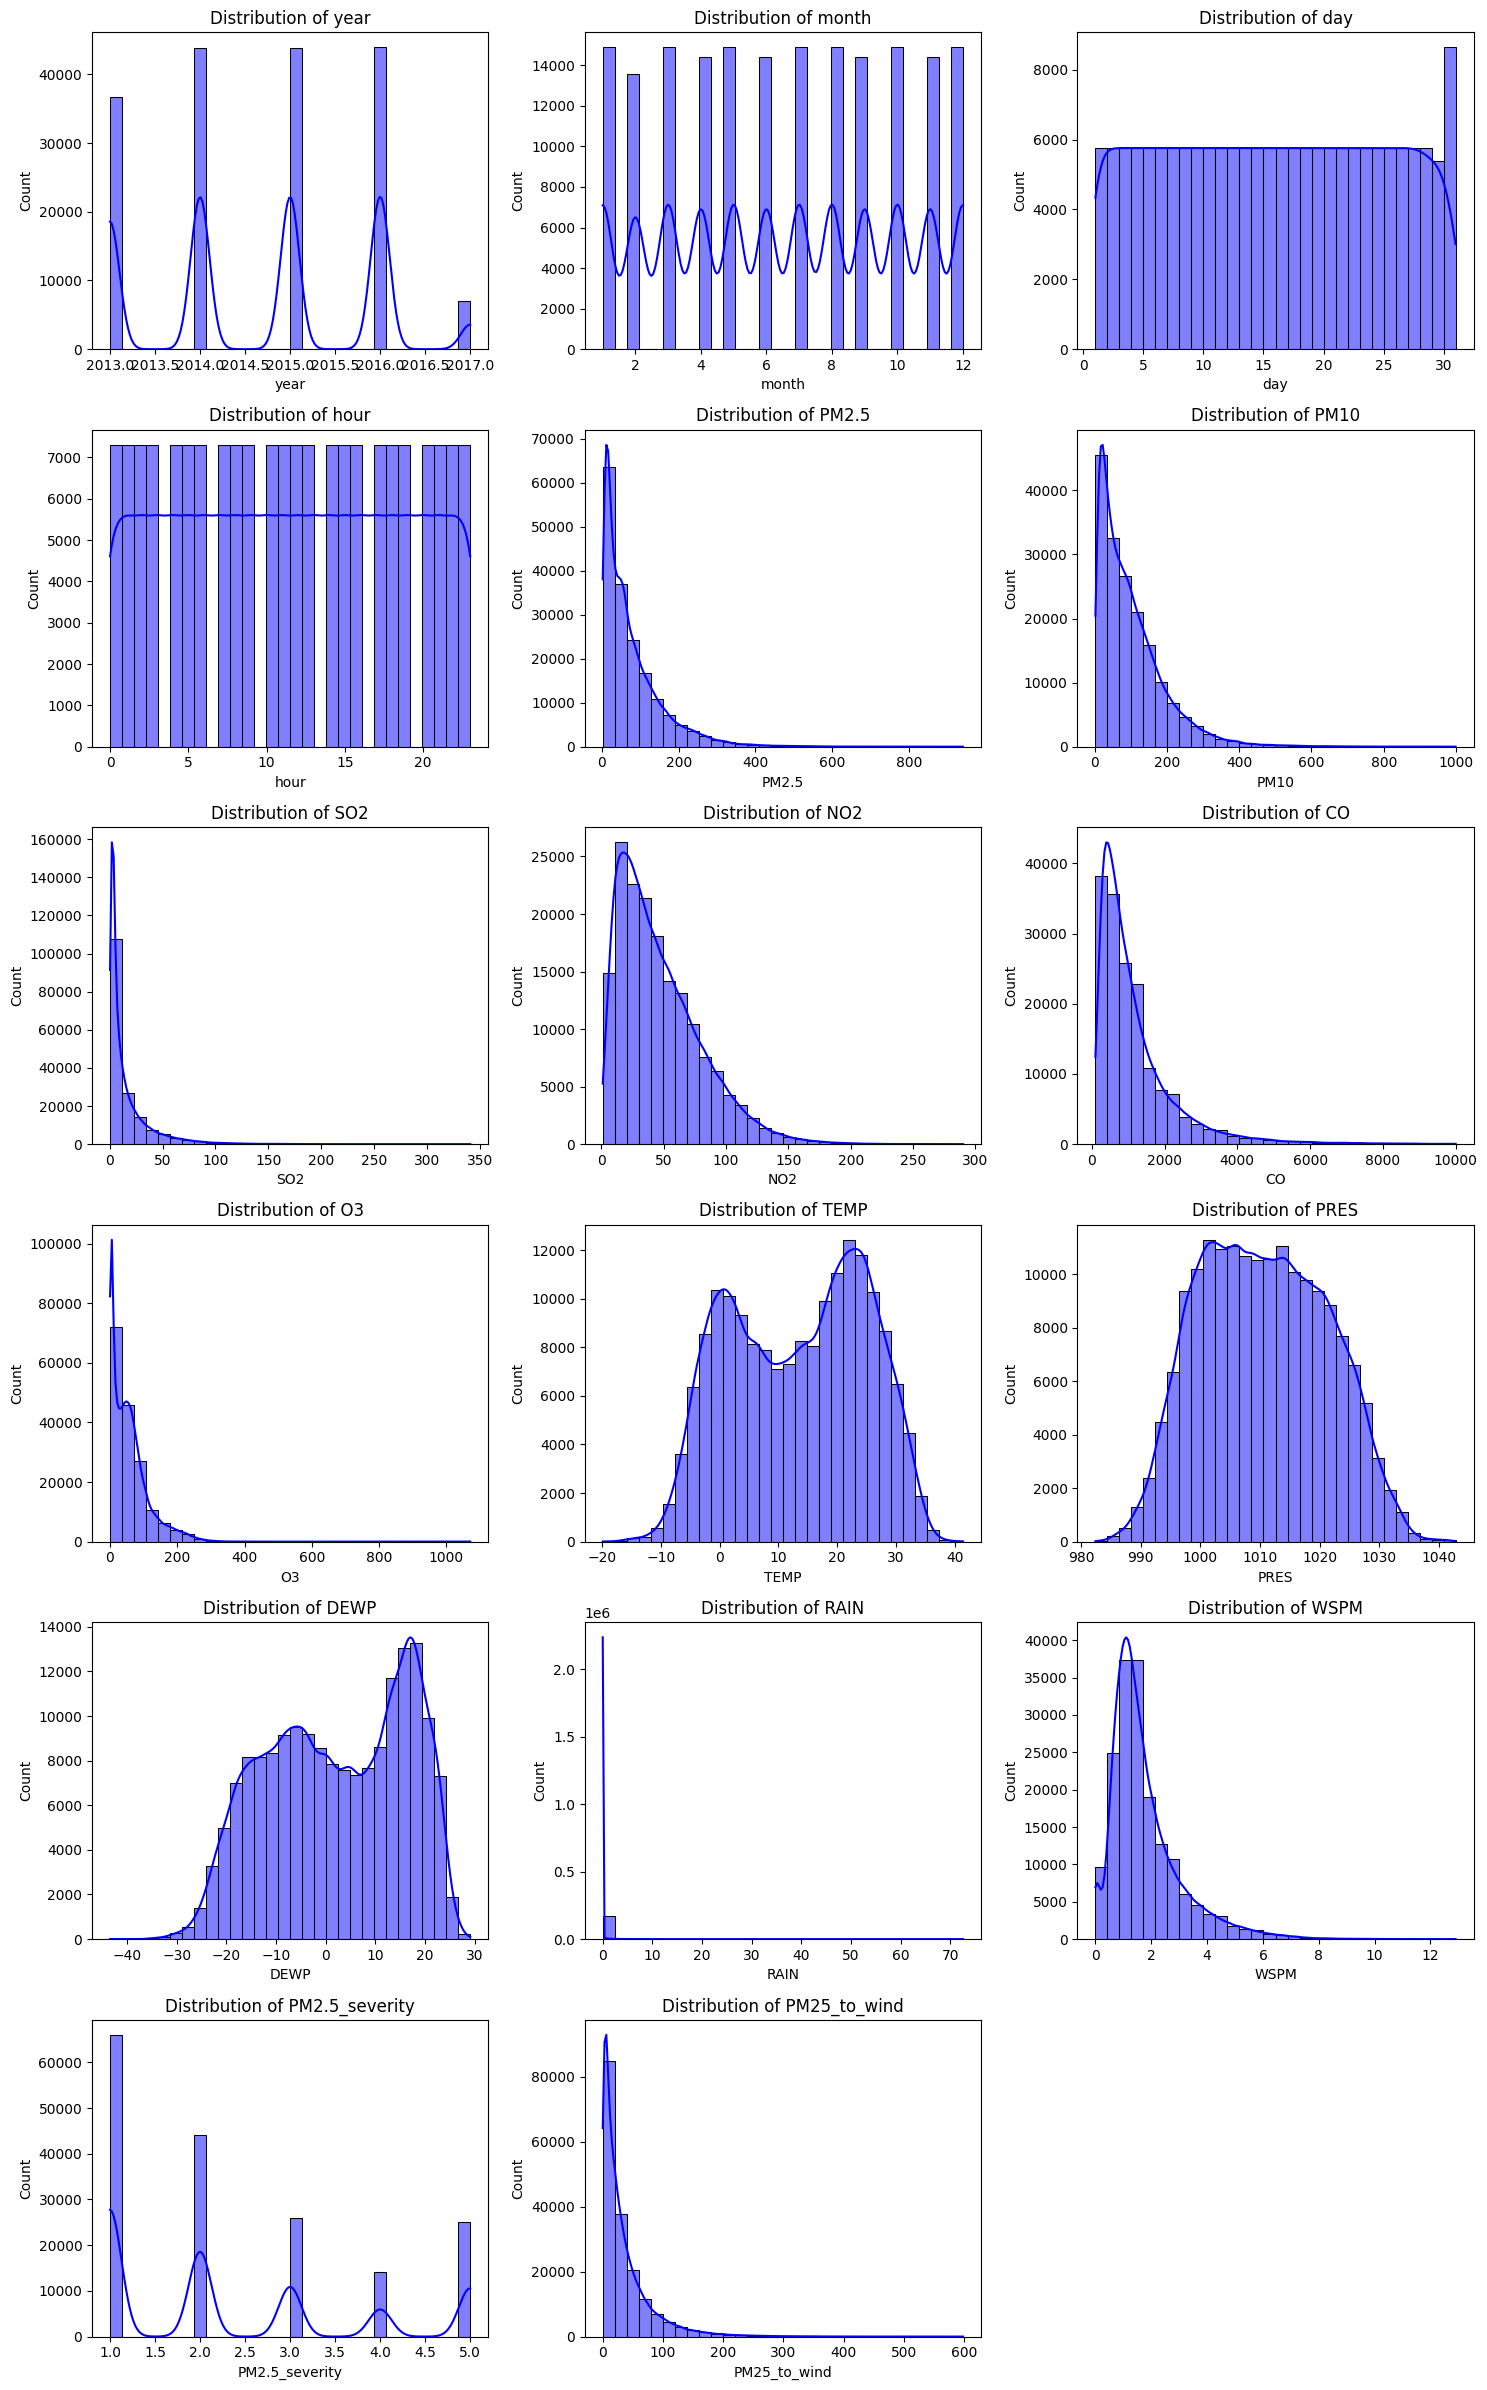

In [92]:
numerical_cols = df.select_dtypes(include=['int64', 'float64','bool']).columns


num_features = len(numerical_cols)
num_rows = int(np.ceil(num_features / 3))

plt.figure(figsize=(15, num_rows * 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

To visualize the distribution of air quality categories, I created a pie chart showing the percentage of each `PM2.5_category`.

I used color coding to clearly distinguish each category, and exploded the 'Medium' slice to emphasize the most frequent level. This visualization gives a quick overview of how often each air quality condition occurs in the data.



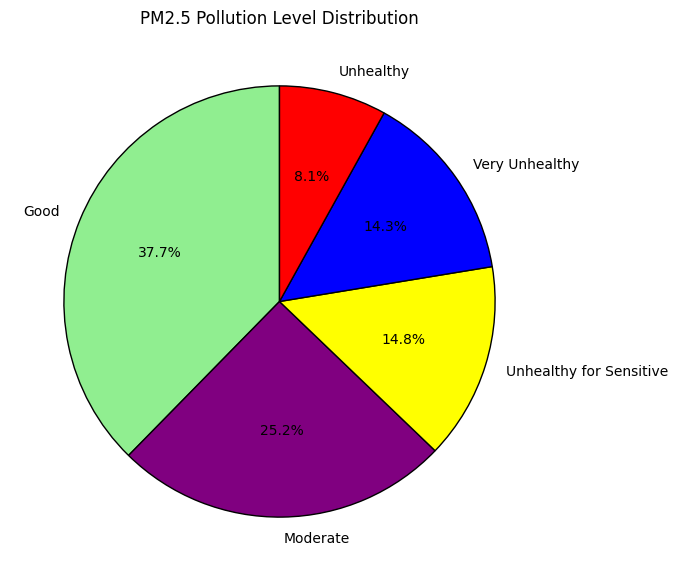

In [95]:
weather = df['PM2.5_category'].value_counts()
labels = weather.index.tolist()

color_map = {'Good': 'lightgreen', 'Moderate' : 'purple', 'Unhealthy for Sensitive' : 'Yellow', 'Unhealthy': 'red', 'Very Unhealthy': 'blue'}
colors = [color_map[label] for label in labels]


plt.figure(figsize=(7, 7))
plt.pie(weather, labels=labels, autopct='%1.1f%%', colors=colors,
        explode=[0.1 if label == 'Medium' else 0 for label in labels],
        startangle=90, wedgeprops={'edgecolor': 'black'})

plt.title('PM2.5 Pollution Level Distribution')
plt.show()